In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data


In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = 'raw_audio_files.csv'

config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.regression import AutoSklearnRegressor

## Read the extracted features from the CSV

In [2]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Data used in SOA models

In [3]:
df_soa = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df_soa.loc[df_soa['Emotion'] == 'excited', 'Emotion'] = 'happy'
df_soa.loc[df_soa['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df_soa.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


### Valence Variation for each Emotion Label

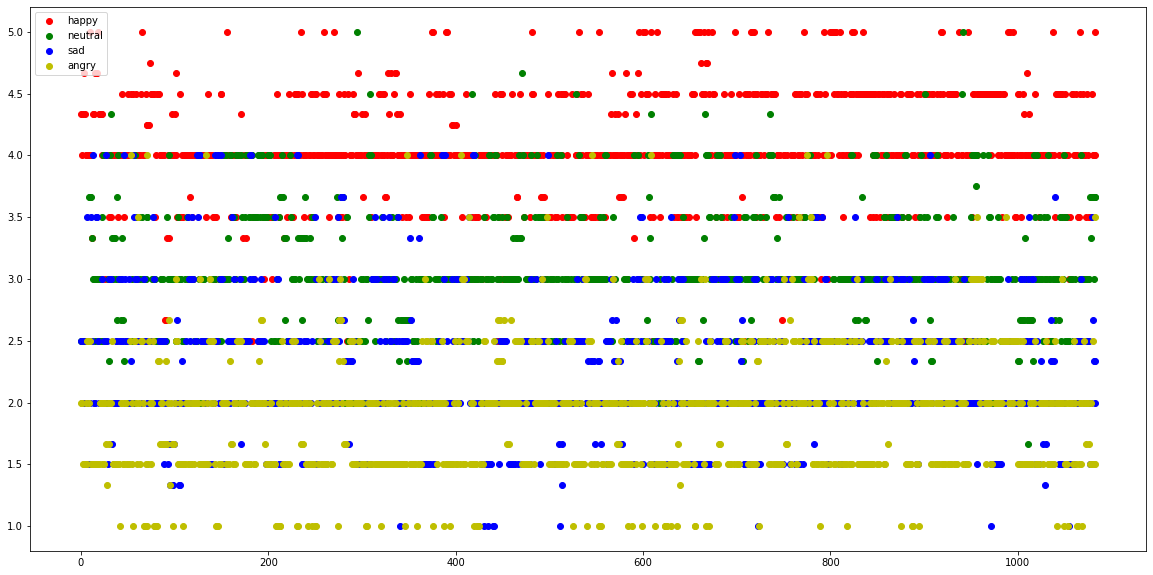

In [12]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'happy']['Valence'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'neutral']['Valence'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'sad']['Valence'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'angry']['Valence'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

### Activation Variation for each Emotion Label

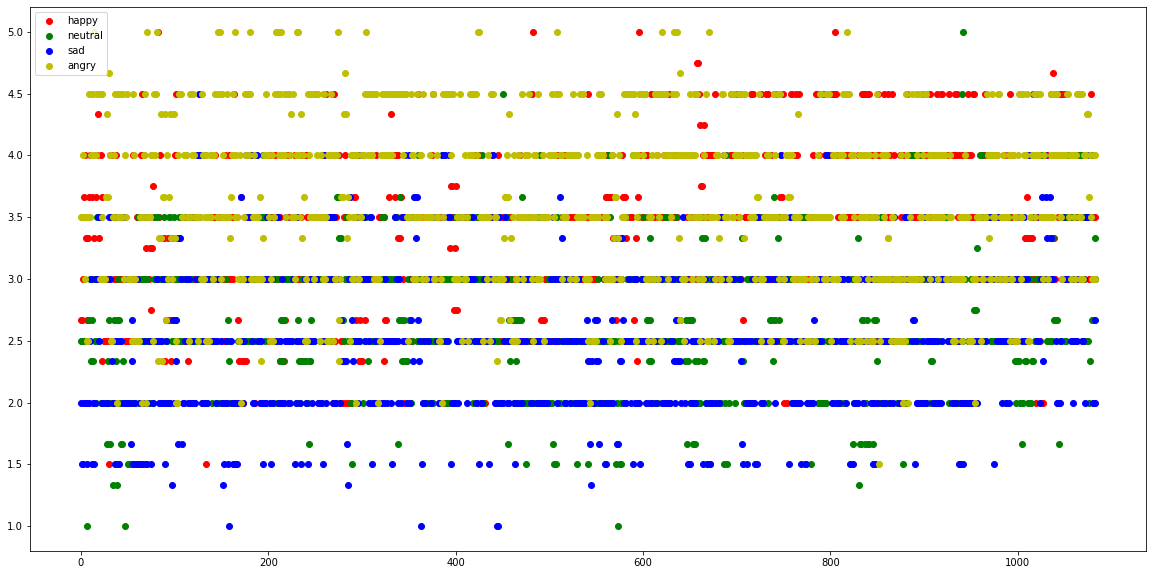

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'happy']['Activation'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'neutral']['Activation'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'sad']['Activation'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'angry']['Activation'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

### Dominance Variation for each Emotion Label

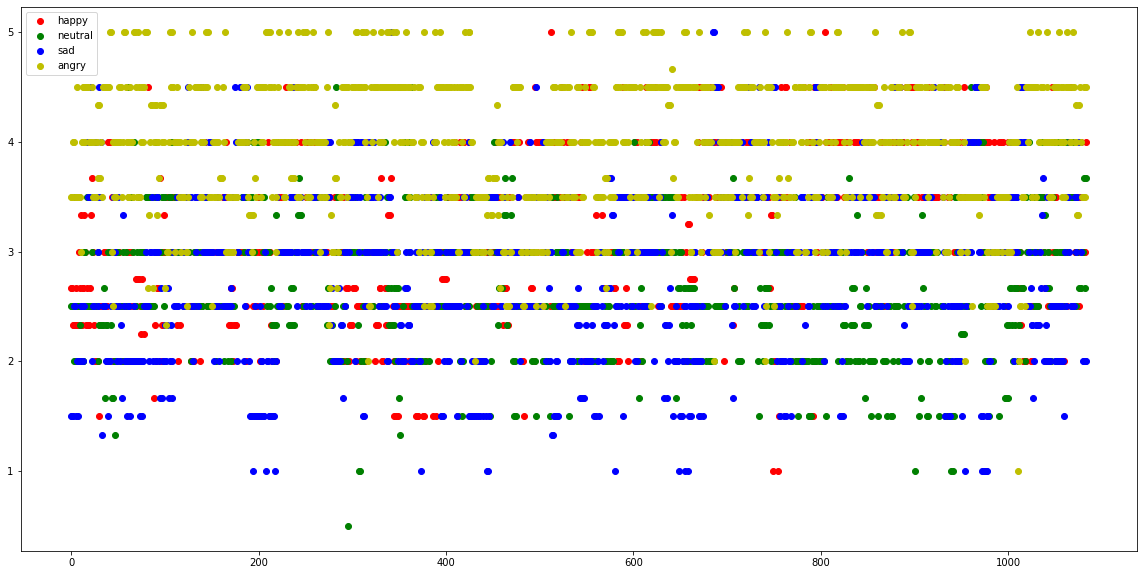

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'happy']['Dominance'][:1084], 'ro', label="happy")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'neutral']['Dominance'][:1084], 'go', label="neutral")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'sad']['Dominance'][:1084], 'bo', label="sad")
plt.plot([i for i in range(1084)], df_soa.loc[df_soa['Emotion'] == 'angry']['Dominance'][:1084], 'yo', label="angry")
plt.legend(loc="upper left")
plt.show()

### Maybe improvised data is more adequate to the problem

In [ ]:
df_soa[df_soa['Interaction'] == 'improvised'].groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,289
happy,947
neutral,1099
sad,608


### The duration of the audio can have importance

In [ ]:
df_soa[df_soa['Duration'] >= 2.5].groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,813
happy,1170
neutral,1105
sad,843


In [ ]:
def plot_cm_predictions(model, input_data, labels, cv=5, draw_corr_matrix=True, verbose=1, n_jobs=4):
    y_pred = cross_val_predict(model, input_data, labels, cv=cv, verbose=verbose, n_jobs=n_jobs)

    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero one loss: ", metrics.zero_one_loss(labels, y_pred))
    print("mean absolute error: ", metrics.mean_absolute_error(labels, y_pred))

    print(metrics.classification_report(labels, y_pred))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0)
        plt.show()

## Models

In [4]:
data = df_soa.iloc[:,8:]
regression_labels = df_soa.iloc[:,5:8].values
categorical_labels = np.ravel(df_soa.iloc[:,4:5].values)

### Simple Random Forests
#### Categorical Problem (anger, happiness (+ excited), neutral, sadness)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   30.1s finished


accuracy:  0.4952088229976496
f1 score macro:  0.5128402898669654
f1 score micro:  0.4952088229976496
precision score:  0.5235160408175284
recall score:  0.5050289689027115
hamming loss:  0.5047911770023504
matthews corrcoef:  0.31341736401352394
zero one loss:  0.5047911770023503
mean absolute error:  0.7868378231784487
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      1103
           1       0.41      0.45      0.42      1636
           2       0.60      0.57      0.58      1084
           3       0.45      0.47      0.46      1708

    accuracy                           0.50      5531
   macro avg       0.52      0.51      0.51      5531
weighted avg       0.50      0.50      0.50      5531



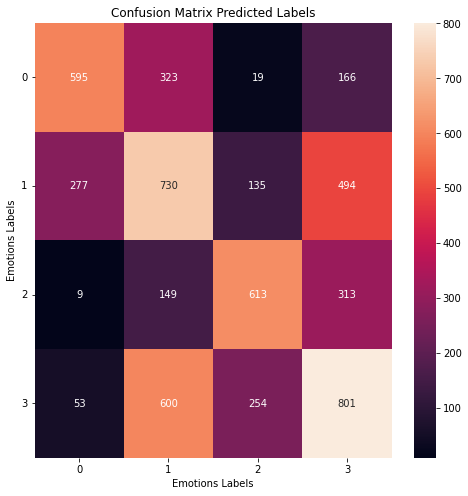

In [ ]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, categorical_labels)

#### Regression Problem (Valence, Activation, Dominance)

In [ ]:
model = RandomForestRegressor(random_state=1, max_features=None)
pred_values = cross_val_predict(model, data.values, regression_labels, cv=5, verbose=1, n_jobs=8)
print('MAE: %.3f' % metrics.mean_absolute_error(pred_values, regression_labels))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.5s


MAE: 0.663


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   22.2s finished


### AutoSKlearn

#### Categorical Problem (anger, happiness (+ excited), neutral, sadness)

In [ ]:
model = AutoSklearnClassifier(
    max_models_on_disc=None,
    resampling_strategy='cv',
    resampling_strategy_arguments={'cv': {'folds': 5}},
    seed=1,
    n_jobs=-1
)
model.fit(data.values, categorical_labels)

AutoSklearnClassifier(max_models_on_disc=None, n_jobs=-1,
                      per_run_time_limit=720, resampling_strategy='cv',
                      resampling_strategy_arguments={'cv': {'folds': 5},
                                                     'folds': 5})

In [ ]:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: af569de4-f17d-11ec-8351-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.606400
  Number of target algorithm runs: 39
  Number of successful target algorithm runs: 31
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 1



In [ ]:
model.performance_over_time_

,Timestamp,ensemble_optimization_score,single_best_optimization_score,single_best_train_score
43,2022-06-21 16:19:24.000000,NaN,0.604231,1.00000
41,2022-06-21 16:19:24.000000,NaN,0.604231,1.00000
40,2022-06-21 16:19:24.000000,NaN,0.604231,1.00000
39,2022-06-21 16:19:24.000000,NaN,0.604231,1.00000
38,2022-06-21 16:19:24.000000,NaN,0.604231,1.00000
...,...,...,...,...
26,2022-06-21 17:00:29.335571,0.623215,0.606400,0.98183
27,2022-06-21 17:00:29.335571,0.623215,0.606400,0.98183
28,2022-06-21 17:00:29.335571,0.623215,0.606400,0.98183
22,2022-06-21 17:00:29.335571,0.623215,0.606400,0.98183


In [ ]:
model.show_models()

{2: {'cost': 0.3957693003073585,
  'ensemble_weight': 0.02,
  'estimators': [{'balancing': Balancing(random_state=1),
    'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f20de5b2550>,
    'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f20e7116a90>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f20de5b2750>,
    'sklearn_classifier': RandomForestClassifier(max_features=4, n_estimators=512, n_jobs=1,
                           random_state=1, warm_start=True)},
   {'balancing': Balancing(random_state=1),
    'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f20dc394b90>,
    'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f20dc384310>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice

In [ ]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
24,1,0.02,gradient_boosting,0.393600,62.607876
2,2,0.02,random_forest,0.395769,93.652015
19,3,0.04,random_forest,0.399747,147.364214
17,4,0.08,lda,0.402097,67.067775
5,5,0.02,gradient_boosting,0.407702,22.090618
25,6,0.02,gradient_boosting,0.414572,73.311230
16,7,0.04,random_forest,0.415115,98.022274
27,8,0.06,lda,0.453083,17.005109
8,9,0.02,passive_aggressive,0.483818,7.822896


#### Regression Problem (Valence, Activation, Dominance)

In [ ]:
model = AutoSklearnRegressor(
    max_models_on_disc=None,
    resampling_strategy='cv',
    resampling_strategy_arguments={'cv': {'folds': 5}},
    seed=1,
    n_jobs=-1
)
model.fit(data.values, regression_labels)

AutoSklearnRegressor(max_models_on_disc=None, n_jobs=-1, per_run_time_limit=720,
                     resampling_strategy='cv',
                     resampling_strategy_arguments={'cv': {'folds': 5},
                                                    'folds': 5})

In [9]:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: 06e5a0d4-f272-11ec-8190-0242ac1c0002
  Metric: r2
  Best validation score: 0.363922
  Number of target algorithm runs: 38
  Number of successful target algorithm runs: 20
  Number of crashed target algorithm runs: 2
  Number of target algorithms that exceeded the time limit: 8
  Number of target algorithms that exceeded the memory limit: 8



In [11]:
model.performance_over_time_

,Timestamp,ensemble_optimization_score,single_best_optimization_score,single_best_train_score
19,2022-06-22 21:27:09.000000,NaN,-0.346724,1.0000
0,2022-06-22 21:27:10.100038,-0.000397,-0.346724,1.0000
20,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
23,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
24,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
25,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
26,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
27,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
28,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358
22,2022-06-22 21:28:23.000000,-0.000397,0.363922,0.5358


In [12]:
model.show_models()

{6: {'cost': 0.6360783057613786,
  'ensemble_weight': 0.34,
  'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fb30fb656d0>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fb30f7b3e10>,
    'regressor': <autosklearn.pipeline.components.regression.RegressorChoice at 0x7fb30fce2c50>,
    'sklearn_regressor': ExtraTreesRegressor(max_features=0.6058051610484844, min_samples_leaf=9,
                        min_samples_split=10, n_estimators=512, n_jobs=1,
                        random_state=1, warm_start=True)},
   {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fb30ce27990>,
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fb30fd7af90>,
    'regressor': <autosklearn.pipeline.components.regression.RegressorChoice at 0x7fb30fd7a510>,
   

In [8]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
6,1,0.34,extra_trees,0.636078,31.859377
34,2,0.42,k_nearest_neighbors,0.641229,10.371204
8,3,0.08,random_forest,0.649275,72.195437
29,4,0.08,random_forest,0.651304,85.092954
30,5,0.08,random_forest,0.660702,97.843856


### Convolution Neural Networks
#### Categorical Problem (anger, happiness (+ excited), neutral, sadness)

In [ ]:
def build_model_0(input_shape=(24, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(data.iloc[0].shape[0],1)).summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization (BatchN  (None, 20, 256)          1024      Y          
 ormalization)                                                              
                                                                            
 activation (Activation)     (None, 20, 256)           0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 16, 128)           163968    Y          
                                                                            
 activation_1 (Activation)   (None, 16, 128)           0         Y          
                                                        

In [ ]:
def categorical_cross_validation(callbacks, no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=4)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 0
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.111961007118225; accuracy of 49.232158064842224%
Training for fold 2 ...
Score for fold 2: loss of 1.1252243518829346; accuracy of 48.73417615890503%
Training for fold 3 ...
Score for fold 3: loss of 1.1336780786514282; accuracy of 46.473780274391174%
Training for fold 4 ...
Score for fold 4: loss of 1.1383367776870728; accuracy of 46.383363008499146%
Training for fold 5 ...
Score for fold 5: loss of 1.1080365180969238; accuracy of 48.19168150424957%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 1.111961007118225 - Accuracy: 49.232158064842224%
> Fold 2 - Loss: 1.1252243518829346 - Accuracy: 48.73417615890503%
> Fold 3 - Loss: 1.1336780786514282 - Accuracy: 46.473780274391174%
> Fold 4 - Loss: 1.1383367776870728 - Accuracy: 46.383363008499146%
> Fold 5 - Loss: 1.1080365180969238 - Accuracy: 48.19168150424

#### Regression Problem (Valence, Activation, Dominance)

Note: Here Stratified K-Fold cannot be used because it has a continuous multi output label, so the distribution of emotions per fold is not going to be balanced.

Could use the categorical emotion to generate the folds and then use the regression labels

In [ ]:
def regression_cross_validation(callbacks, no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
  mae_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,5:8]

  for train, test in kfold.split(X, y):
    model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=4)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    mae_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(mae_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MAE: {mae_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500 # try 300 or 700
batch_size = 32 # try 16
learning_rate=1e-5 # try 1e-5
loss = MeanAbsoluteError()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 0
num_folds = 5

regression_cross_validation(callback, no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5870349407196045; mae of 58.70349407196045%
Training for fold 2 ...
Score for fold 2: loss of 0.615779459476471; mae of 61.577945947647095%
Training for fold 3 ...
Score for fold 3: loss of 0.5887221693992615; mae of 58.87221693992615%
Training for fold 4 ...
Score for fold 4: loss of 0.5906510353088379; mae of 59.06510353088379%
Training for fold 5 ...
Score for fold 5: loss of 0.6135765910148621; mae of 61.35765314102173%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.5870349407196045 - MAE: 58.70349407196045%
> Fold 2 - Loss: 0.615779459476471 - MAE: 61.577945947647095%
> Fold 3 - Loss: 0.5887221693992615 - MAE: 58.87221693992615%
> Fold 4 - Loss: 0.5906510353088379 - MAE: 59.06510353088379%
> Fold 5 - Loss: 0.6135765910148621 - MAE: 61.35765314102173%
-------------------------------------------------

## AutoKeras

In [ ]:
def categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"best_regression_keras_model_fold_{fold_no}")
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

# classifier that tries 100 different keras classifier models
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 1
num_folds = 5

categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

Trial 84 Complete [00h 00m 03s]
val_accuracy: 0.13287514448165894

Best val_accuracy So Far: 0.743413507938385
Total elapsed time: 00h 05m 42s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6184 - accuracy: 0.2493
Epoch 2/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6064 - accuracy: 0.2522
Epoch 3/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5952 - accuracy: 0.2592
Epoch 4/500
277/277 [==============================] - 0s 2ms/step - loss: 1.5787 - accuracy: 0.2615
Epoch 5/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5554 - accuracy: 0.2712
Epoch 6/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5569 - accuracy: 0.2748
Epoch 7/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5372 - accuracy: 0.2843
Epoch 8/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5279 - accuracy: 0.2800
Epoch 9/500

## Raw Audio Signal as the Input Feature

In [5]:
raw_df = pd.read_csv(RAW_AUDIO_FILES)
print(f"Number of Audio Files: {raw_df.shape[0]}")
raw_df = raw_df.set_index('File')
raw_df_soa = raw_df[raw_df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
raw_df_soa.loc[raw_df_soa['Emotion'] == 'excited', 'Emotion'] = 'happy'
raw_df_soa.loc[raw_df_soa['Emotion_Id'] == 5, 'Emotion_Id'] = 1
raw_df_soa.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 10039


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [6]:
def get_signal_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, _ = librosa.load(audio_file, res_type='kaiser_fast')
    return y, raw_df_soa.loc[audio_file]["Emotion"]

AUTOTUNE = tf.data.AUTOTUNE

filenames_ds = tf.data.Dataset.list_files([str(file) for file in raw_df_soa.index.values])

waveform_ds = filenames_ds.map(
    lambda x: tf.py_function(get_signal_and_label, [x], [tf.float32, tf.string]),
    num_parallel_calls=AUTOTUNE)

2022-06-24 09:36:23.628708: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


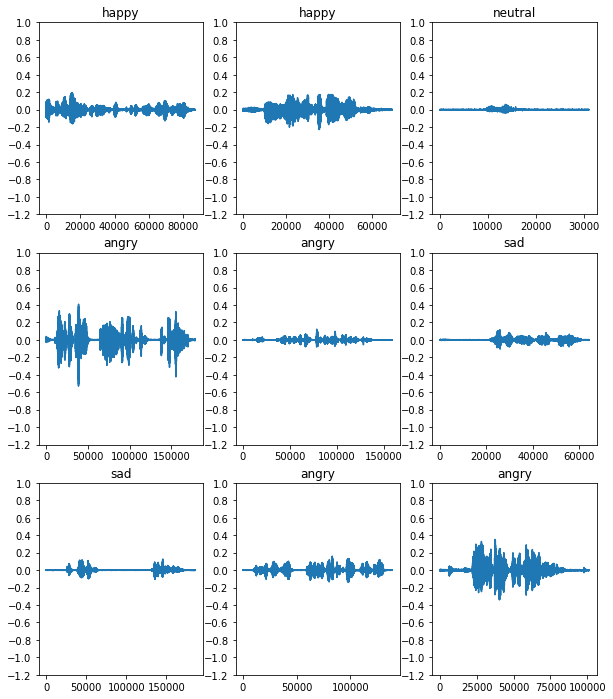

In [7]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [9]:
def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.list_files([str(file) for file in raw_df_soa.index.values])
  output_ds = filenames_ds.map(
    lambda x: tf.py_function(get_signal_and_label, [x], [tf.float32, tf.string]),
    num_parallel_calls=AUTOTUNE)
  return output_ds

batch_size = 64
dataset = preprocess_dataset(raw_df_soa.index.values)
data_ds = dataset.batch(batch_size)
dataset = dataset.cache().prefetch(AUTOTUNE)

In [ ]:
def categorical_cross_validation3(no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1

  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"best_regression_keras_model_fold_{fold_no}")
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

# classifier that tries 100 different keras classifier models
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 1
num_folds = 5

categorical_cross_validation3(no_epochs, batch_size, loss, optimizer, verbosity, num_folds)